In [1]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
import numpy as np

data = pd.read_csv("preprocessed_apartment_rentals_no_state_dummies_nocluster.csv")

# Features und Ziel
X = data.drop(columns=["price"])
y = data["price"]
y = np.log1p(y)  # Log-Transformation


# Regression

# Ridge Regression

In [2]:
from Nested_CV_targetEncoding import NestedCVRegressorWithTargetEncoding

In [3]:
from sklearn.linear_model import Ridge
import numpy as np
from sklearn.preprocessing import StandardScaler
ridge_params = {"alpha": np.logspace(-3, 3, 10)}

ridge_cv = NestedCVRegressorWithTargetEncoding(model = Ridge(), param_grid = ridge_params, encode_cols=["state", "cityname"], scaler = StandardScaler)
ridge_cv.run(X, y, output=True)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Outer Fold 1/5 | Best Params: {'model__alpha': np.float64(215.44346900318823)} | Fit Time: 3.952s | Outer R²: 0.682 | MSE: 0.057
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Outer Fold 2/5 | Best Params: {'model__alpha': np.float64(215.44346900318823)} | Fit Time: 3.400s | Outer R²: 0.673 | MSE: 0.058
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Outer Fold 3/5 | Best Params: {'model__alpha': np.float64(215.44346900318823)} | Fit Time: 4.518s | Outer R²: 0.672 | MSE: 0.059
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Outer Fold 4/5 | Best Params: {'model__alpha': np.float64(215.44346900318823)} | Fit Time: 1.995s | Outer R²: 0.674 | MSE: 0.058
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Outer Fold 5/5 | Best Params: {'model__alpha': np.float64(215.44346900318823)} | Fit Time: 1.762s | Outer R²: 0.679 | MSE: 0.057


In [4]:
number_outer_cv_splits = 5
model_evaluation = pd.DataFrame({"Fold": range(1, number_outer_cv_splits+1)})
model_evaluation['Modell'] = ['Ridge_target_encoding'] * number_outer_cv_splits
model_evaluation['R_2'] = ridge_cv.get_r2_scores()
model_evaluation['MSE'] = ridge_cv.get_mse_scores()
model_evaluation["runtime"] = ridge_cv.get_fit_times()
model_evaluation

,Fold,Modell,R_2,MSE,runtime
0,1,Ridge_target_encoding,0.682413,0.056991,3.951991
1,2,Ridge_target_encoding,0.673289,0.057728,3.399831
2,3,Ridge_target_encoding,0.671573,0.058987,4.518007
3,4,Ridge_target_encoding,0.674473,0.057554,1.995248
4,5,Ridge_target_encoding,0.679260,0.056784,1.762024


In [5]:
model_evaluation.to_pickle('benchmarking/Ridgeregression_targetencoding_y_log_transformed.pkl')

In [6]:
from sklearn.linear_model import Lasso
import numpy as np
lasso_params = {"alpha": np.logspace(-3, 3, 10)}

lasso_cv = NestedCVRegressorWithTargetEncoding(model = Lasso(), param_grid = lasso_params, encode_cols=["state", "cityname"])
lasso_cv.run(X, y, output=True)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


C:\Users\User\AppData\Roaming\Python\Python311\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.293e+07, tolerance: 3.664e+06
  model = cd_fast.enet_coordinate_descent(
C:\Users\User\AppData\Roaming\Python\Python311\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.293e+07, tolerance: 3.664e+06
  model = cd_fast.enet_coordinate_descent(


Outer Fold 1/5 | Best Params: {'model__alpha': np.float64(0.004641588833612777)} | Fit Time: 6.314s | Outer R²: 0.654 | MSE: 163445.802
Fitting 5 folds for each of 10 candidates, totalling 50 fits


C:\Users\User\AppData\Roaming\Python\Python311\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.384e+07, tolerance: 3.682e+06
  model = cd_fast.enet_coordinate_descent(
C:\Users\User\AppData\Roaming\Python\Python311\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.384e+07, tolerance: 3.682e+06
  model = cd_fast.enet_coordinate_descent(


Outer Fold 2/5 | Best Params: {'model__alpha': np.float64(0.021544346900318832)} | Fit Time: 5.720s | Outer R²: 0.644 | MSE: 165297.546
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Outer Fold 3/5 | Best Params: {'model__alpha': np.float64(0.1)} | Fit Time: 1.514s | Outer R²: 0.645 | MSE: 165335.833
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Outer Fold 4/5 | Best Params: {'model__alpha': np.float64(0.1)} | Fit Time: 2.565s | Outer R²: 0.640 | MSE: 167038.601
Fitting 5 folds for each of 10 candidates, totalling 50 fits


C:\Users\User\AppData\Roaming\Python\Python311\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.136e+07, tolerance: 3.681e+06
  model = cd_fast.enet_coordinate_descent(


Outer Fold 5/5 | Best Params: {'model__alpha': np.float64(0.001)} | Fit Time: 5.186s | Outer R²: 0.648 | MSE: 163425.284


C:\Users\User\AppData\Roaming\Python\Python311\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.136e+07, tolerance: 3.681e+06
  model = cd_fast.enet_coordinate_descent(


# Analyse
Welche Preise werden gut, welche schlechter vorhergesagt?

Final Alpha: 215.44346900318823
Test MSE: 147503.49684983442
Test R²: 0.6824114991358402


C:\Users\User\AppData\Local\Temp\ipykernel_4435024\2933609623.py:71: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


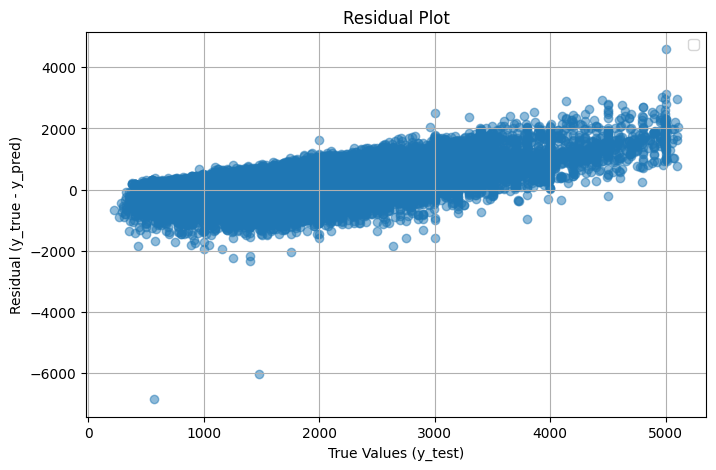

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from category_encoders import TargetEncoder

# ---------------------------------------------------------
# 1️⃣ Finales Alpha aus Nested CV (von dir vorher berechnet)
# ---------------------------------------------------------
best_parameters = ridge_cv.get_best_params()   # liefert Liste von dicts

alpha_values = [float(list(p.values())[0]) for p in best_parameters]
final_alpha = np.median(alpha_values)
print("Final Alpha:", final_alpha)

# ---------------------------------------------------------
# 2️⃣ Train/Test Split
# ---------------------------------------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)


# ---------------------------------------------------------
# 3️⃣ Target Encoding korrekt (nur auf TRAIN fitten!)
# ---------------------------------------------------------
te = TargetEncoder(cols=["state", "cityname"])   # deine kategorische Spalte

# Auf TRAIN fitten
te.fit(X_train[["state", "cityname"]], y_train)

# Transformieren
X_train_enc = X_train.copy()
X_test_enc = X_test.copy()

X_train_enc[["cityname", "state"]] = te.transform(X_train[["cityname", "state"]])
X_test_enc[["cityname", "state"]] = te.transform(X_test[["cityname", "state"]])

# ---------------------------------------------------------
# 4️⃣ Finales Ridge-Modell trainieren
# ---------------------------------------------------------
final_model = Ridge(alpha=final_alpha)
final_model.fit(X_train_enc, y_train)

# ---------------------------------------------------------
# 5️⃣ Vorhersagen + Scores
# ---------------------------------------------------------
y_pred = final_model.predict(X_train_enc)

mse = mean_squared_error(y_train, y_pred)
r2 = r2_score(y_train, y_pred)

print("Test MSE:", mse)
print("Test R²:", r2)

# ---------------------------------------------------------
# 6️⃣ Residual Plot (Residuals oder Absolute Error)
# ---------------------------------------------------------
residuals = y_train - y_pred
abs_error = np.abs(y_train - y_pred)

plt.figure(figsize=(8,5))
scatter = plt.scatter(y_train, residuals, 
                      alpha=0.5)
plt.xlabel("True Values (y_test)")
plt.ylabel("Residual (y_true - y_pred)")
plt.title("Residual Plot")
plt.grid(True)
#plt.hist(y_test, bins = 50, alpha=0.3, label='y_test', color='red')
plt.legend()
plt.show()